In [4]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

#from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
#from Combined_Agent_Double.utils.random_agent import RandomAgent
#from Combined_Agent_Double.utils.actions import MORE_ACTIONS
#import Combined_Agent_Double.utils.stats_functions as sf

from Agents.Prio_n_step.Prio_DQN_Agent import Prio_DQN_Agent
from Agents.Pablo.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN
from Agents.Random.random_agent import RandomAgent
from Agents.utils.actions import MORE_ACTIONS
import Agents.utils.stats_functions as sf
import hockey.hockey_env as h_env

from Agents.Pablo.Agent import Dueling_DDQN_Agent
from Agents.Tapas_en_Mallorca.old.Agent import Combined_Agent
from Agents.Tapas_en_Mallorca.Adaptative_Dueling_Double_DQN.Agent import Adaptative_Dueling_Double_DQN_better_mem

from importlib import reload

In [5]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 +  563 *i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [ ]:
reload(h_env)
env_name = "../weights/no_prio_agent_23_02_25_n_step_1"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)
#env = gym.make("CartPole-v1", render_mode = "rgb_array")

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

#agent = Adaptative_Dueling_Double_DQN_better_mem(state_space, action_space, seed = seed, eps = 0.01,use_dueling = True, use_double = True, use_noisy = True, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5, env = env, use_more_actions = USE_MORE_ACTIONS)
#agent = Adaptative_Dueling_Double_DQN(state_space, action_space, seed = seed,use_dueling = True, use_double = True, use_noisy = True ,eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], env = env, use_more_actions = USE_MORE_ACTIONS)
agent = Prio_DQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 1,use_prio= False, env = env, use_more_actions = USE_MORE_ACTIONS)
agent.Q.load(env_name, name= "episode_2000")

/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/goon/studium/hockey-en-mallorca/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
INFO:root:Using device: cuda


Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling Network Architecture
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../weights/no_prio_agent_23_02_25_n_step_1/weights/episode_2000.pth


/home/goon/studium/hockey-en-mallorca/src/hockey-env/Agents/Tapas_en_Mallorca/Adaptative_Dueling_Double_DQN/QFunction.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  se

In [7]:
stats, losses = sf.load_stats(env_name)

Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/returns_plot.png


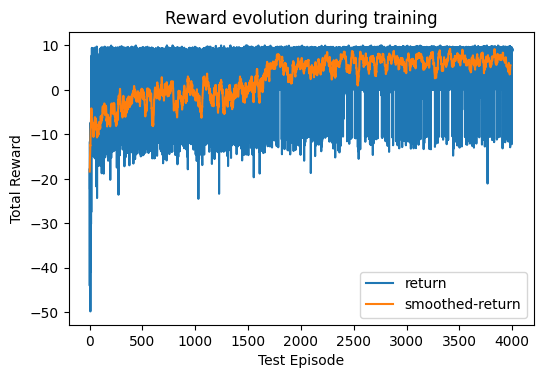

In [8]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/losses_plot.png


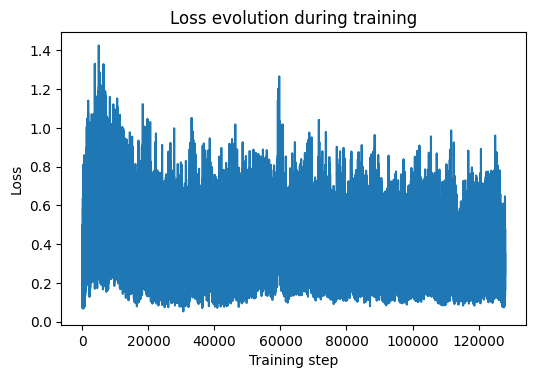

In [9]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/beta_evolution.png


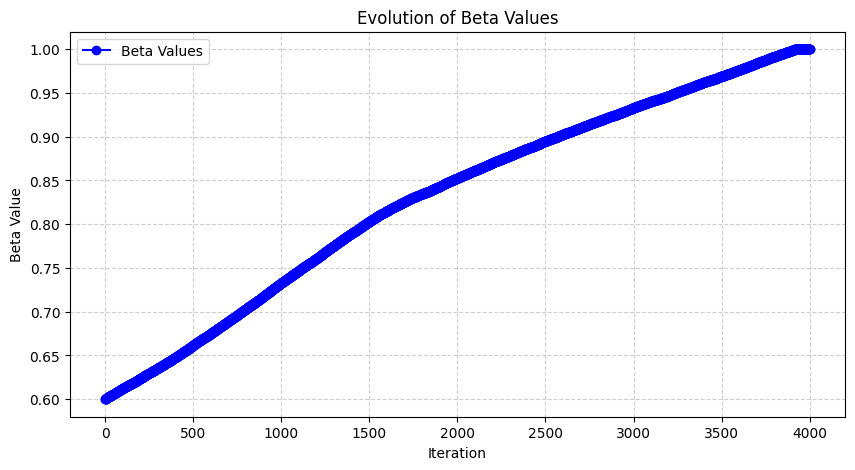

In [10]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/epsilon_evolution.png


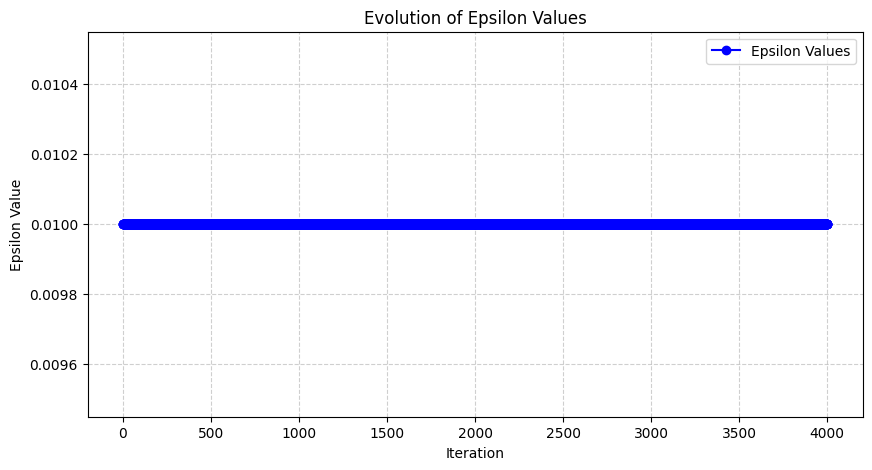

In [11]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/match_evolution.png


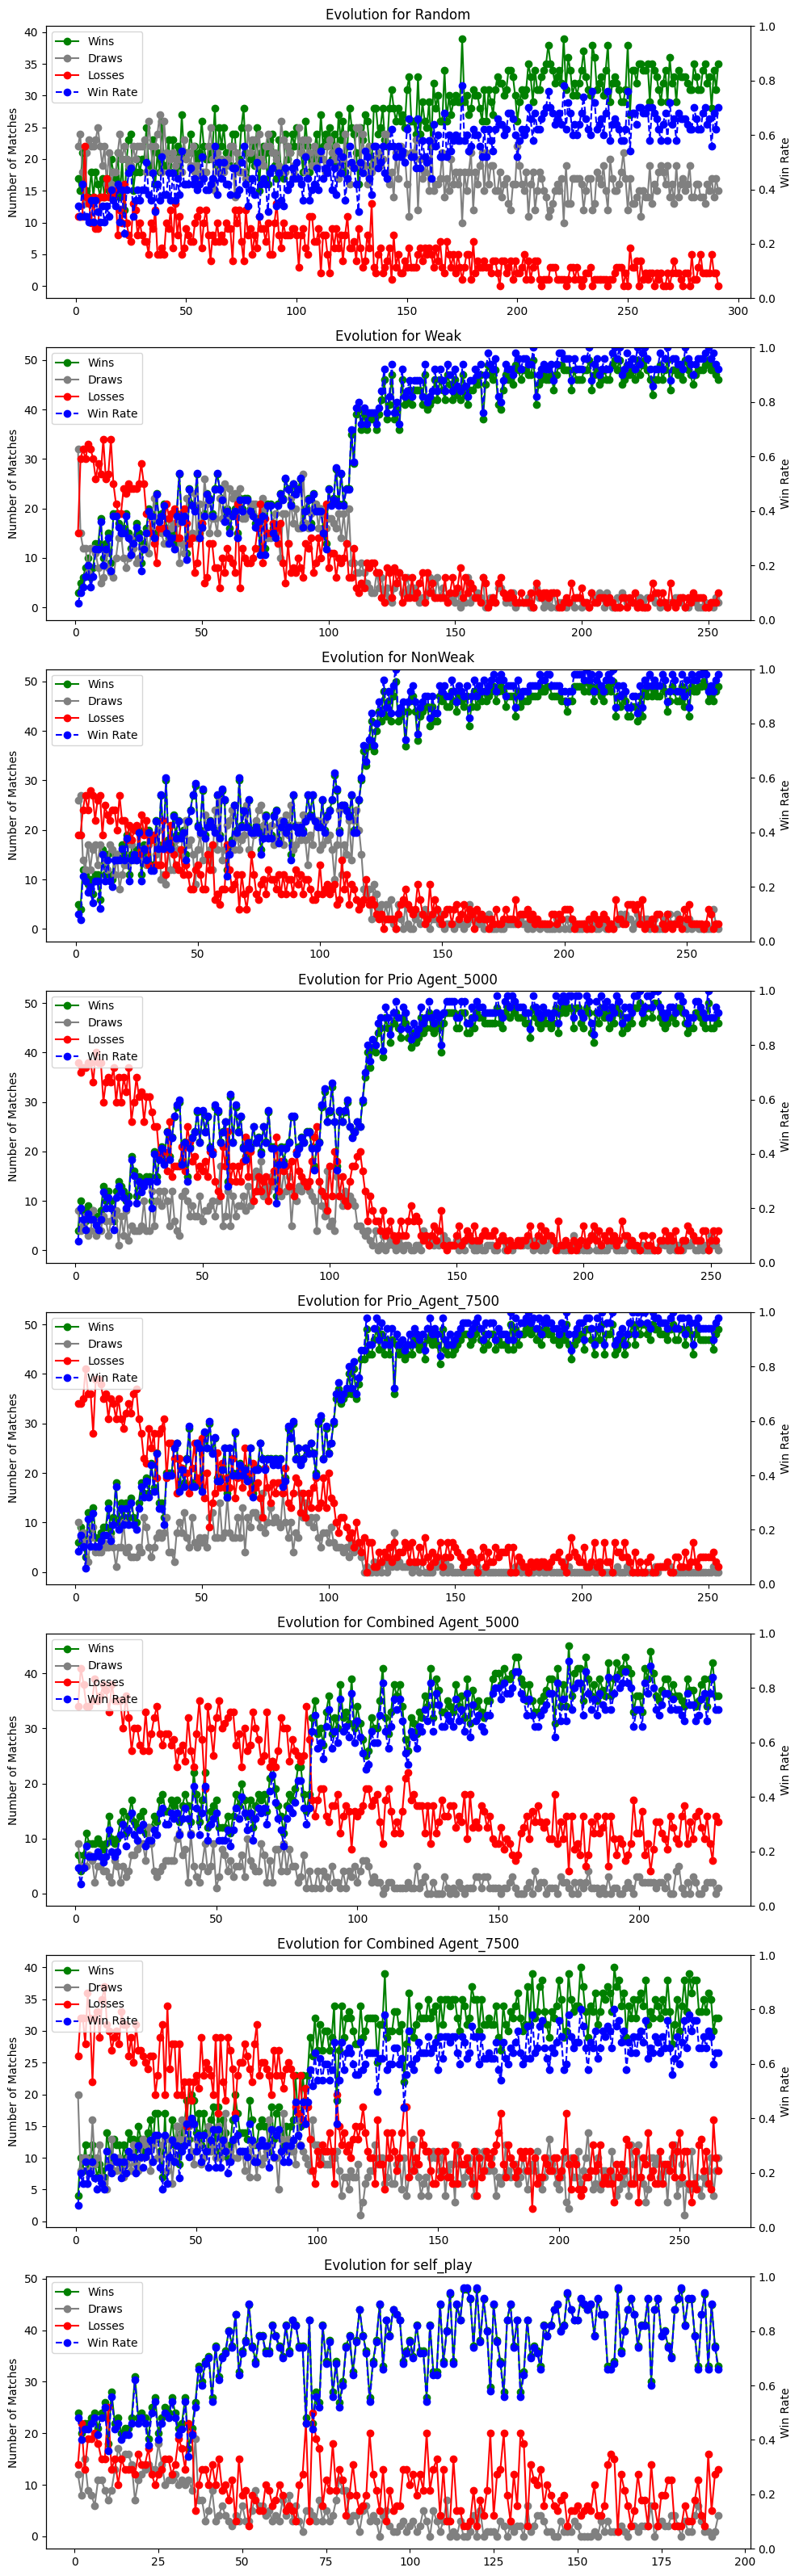

In [12]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history,  [
    "Random",
    "Weak",
    "NonWeak",
    "Prio Agent_5000",
    "Prio_Agent_7500",
    "Combined Agent_5000",
    "Combined Agent_7500",
    "self_play",
], 50)

#sf.plot_match_evolution_by_chunks(env_name, match_history,  ["Weak", "NonWeak" ],50)


In [13]:
def test_agent(agent = agent, opponent = RandomAgent(seed), test_episodes  = len(SEEDS_TEST), max_steps = 30000, opponent_name = "random", agent_name = "prio_agent", env_name = env_name):
   
    test_rewards = []
    test_name = f"{opponent_name}_vs_{agent_name}"
  
    won_games = 0
    lost_games = 0
    tied_games = 0
    for episode in range(test_episodes):

        obs_agent1, _ = env.reset(seed = SEEDS_TEST[episode])
       #state = env.reset(seed = seed)
        env.action_space.seed(seed = SEEDS_TEST[episode])
        obs_agent1= obs_agent1[0] if isinstance(obs_agent1, tuple) else obs_agent1  # Handle Gymnasium compatibility

        obs_agent2 = env.obs_agent_two()
        obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

        total_reward = 0

        frames = []
        
        for t in range(max_steps):

            done = False

            frame = env.render(mode = "rgb_array")
            if frame is not None:
                frames.append(frame)

            a1_cont = agent.get_step(obs_agent1)
            a2 = opponent.act(obs_agent2)

            full_action = np.hstack([a1_cont, a2])

            next_state, reward, done, truncated, _ = env.step(full_action)
            
            total_reward += reward

            obs_agent1 = next_state
            obs_agent2 = env.obs_agent_two()

            if done or truncated: break

        test_rewards.append(total_reward)
        won = env.winner == 1
        if won:
            won_games += 1
        tie = env.winner == 0
        if tie:
            tied_games += 1
        lost = not won and not tie
        if lost:
            lost_games += 1
        string = "Won" if won else "Tie" if tie else "Lost"
        print(f"Test Episode {episode+1}, Total Reward: {total_reward}", string)
       
        
        if frames:
            os.makedirs(f"{env_name}/test_gifs/{test_name}", exist_ok=True)
            imageio.mimsave(f"{env_name}/test_gifs/{test_name}/test_episode_{episode+1}.gif", frames, fps=30)

    env.close()
    winrate = won_games / test_episodes
    tie_rate = tied_games / test_episodes
    loss_rate = lost_games / test_episodes
    print(f"Winrate: {winrate}, Tie Rate: {tie_rate}, Loss Rate: {loss_rate}")
    results_name = f"test_results_{test_name}"
    sf.save_test_results(env_name, test_rewards, name = results_name)

Test Episode 1, Total Reward: 8.971065760950786 Won
Test Episode 2, Total Reward: 9.63224248851166 Won
Test Episode 3, Total Reward: 0.0 Tie
Test Episode 4, Total Reward: 6.340657050751831 Won
Test Episode 5, Total Reward: 0.0 Tie
Test Episode 6, Total Reward: 9.353744940425422 Won
Test Episode 7, Total Reward: 9.716122982948093 Won
Test Episode 8, Total Reward: 9.122127605913226 Won
Test Episode 9, Total Reward: 8.92976743725951 Won
Test Episode 10, Total Reward: 9.00082519912718 Won
Winrate: 0.8, Tie Rate: 0.2, Loss Rate: 0.0
Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/test_results_random_vs_prio_agent.png


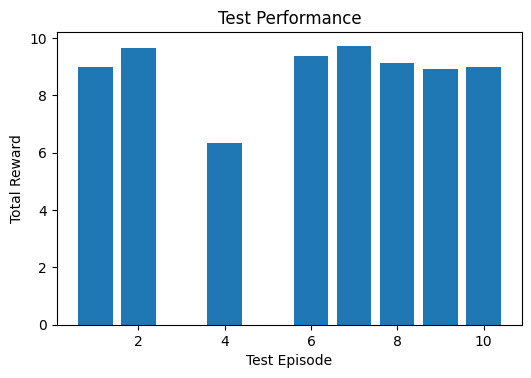

In [14]:
test_agent()

Test Episode 1, Total Reward: 9.853668942037247 Won
Test Episode 2, Total Reward: 9.14446755539105 Won
Test Episode 3, Total Reward: 9.89137012777335 Won
Test Episode 4, Total Reward: 8.922615688262134 Won
Test Episode 5, Total Reward: 8.297636393085385 Won
Test Episode 6, Total Reward: 9.329362125734512 Won
Test Episode 7, Total Reward: 9.654732640390737 Won
Test Episode 8, Total Reward: 8.921931263314248 Won
Test Episode 9, Total Reward: 9.846600847891748 Won
Test Episode 10, Total Reward: 8.970516685730184 Won
Winrate: 1.0, Tie Rate: 0.0, Loss Rate: 0.0
Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/test_results_weak_vs_prio_agent.png


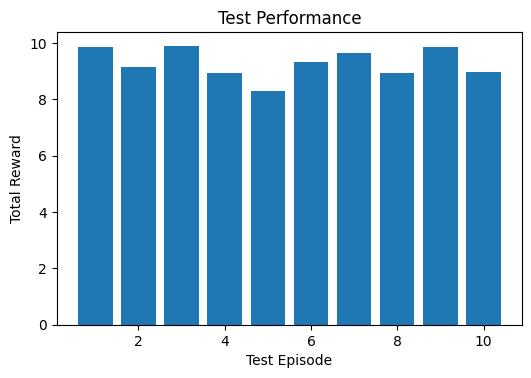

In [15]:
test_agent(opponent = h_env.BasicOpponent(weak=True), opponent_name = "weak", agent_name = "prio_agent")



Test Episode 1, Total Reward: 9.618620931657864 Won
Test Episode 2, Total Reward: 9.639660810054194 Won
Test Episode 3, Total Reward: 7.594602470122381 Won
Test Episode 4, Total Reward: 9.145945056884615 Won
Test Episode 5, Total Reward: 9.40068317103921 Won
Test Episode 6, Total Reward: 9.282524890766107 Won
Test Episode 7, Total Reward: 8.660375139182673 Won
Test Episode 8, Total Reward: 7.909390256088681 Won
Test Episode 9, Total Reward: 9.779954845598906 Won
Test Episode 10, Total Reward: 8.992302546779506 Won
Winrate: 1.0, Tie Rate: 0.0, Loss Rate: 0.0
Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/test_results_non_weak_vs_prio_agent.png


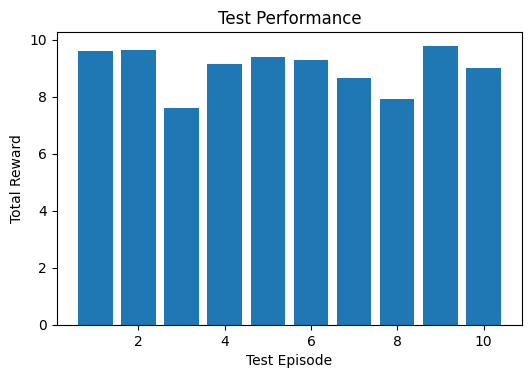

In [16]:
test_agent(opponent = h_env.BasicOpponent(weak=False), opponent_name = "non_weak", agent_name = "prio_agent")

Test Episode 1, Total Reward: -10.473952217567156
Test Episode 2, Total Reward: 9.655537579373695
Test Episode 3, Total Reward: 8.292467197290826
Test Episode 4, Total Reward: 8.889734546570939
Test Episode 5, Total Reward: -10.651793995515115
Test Episode 6, Total Reward: -4.003066335469813
Test Episode 7, Total Reward: 8.692792340392995
Test Episode 8, Total Reward: -12.60882520208229
Test Episode 9, Total Reward: -10.477695713126527
Test Episode 10, Total Reward: -12.24497323553539
Plot saved at ../weights/no_prio_agent_23_02_25_n_step_1/stats/plots/test_results_selfplay.png


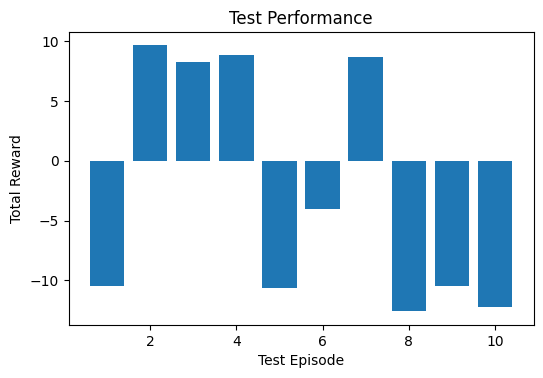

In [17]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)
#opponent.Q.load(env_name, name = "episode_1500")

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    env.action_space.seed(seed)
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.act(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")